# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [1]:
from utils import get_dataset
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import tensorflow as tf
import pandas as pd


%matplotlib inline

In [2]:
dataset_train = get_dataset("/home/workspace/data/train/*.tfrecord")
dataset_test = get_dataset("/home/workspace/data/test/*.tfrecord")

INFO:tensorflow:Reading unweighted datasets: ['/home/workspace/data/train/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/home/workspace/data/train/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 86
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()
INFO:tensorflow:Reading unweighted datasets: ['/home/workspace/data/test/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/home/workspace/data/test/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 3


## Explore Data Format

As it is my first time working with tfrecords, I will explore it a bit more. A good tutorial can be found here: https://www.tensorflow.org/tutorials/load_data/tfrecord

The laebling specs of the Dataset are here: https://github.com/waymo-research/waymo-open-dataset/blob/master/docs/labeling_specifications.md

{'image': <tf.Tensor: shape=(640, 640, 3), dtype=uint8, numpy=
array([[[ 71, 126, 182],
        [ 70, 125, 181],
        [ 67, 122, 178],
        ...,
        [ 67,  71,  56],
        [ 71,  74,  63],
        [ 67,  70,  61]],

       [[ 69, 124, 180],
        [ 70, 125, 181],
        [ 69, 124, 180],
        ...,
        [ 63,  67,  52],
        [ 72,  75,  64],
        [ 65,  68,  57]],

       [[ 69, 124, 180],
        [ 71, 126, 182],
        [ 70, 125, 181],
        ...,
        [ 65,  69,  52],
        [ 67,  71,  57],
        [ 66,  70,  56]],

       ...,

       [[ 72,  81,  90],
        [ 71,  80,  89],
        [ 69,  78,  87],
        ...,
        [ 72,  79,  87],
        [ 69,  76,  84],
        [ 67,  74,  82]],

       [[ 77,  84,  94],
        [ 74,  81,  91],
        [ 71,  80,  89],
        ...,
        [ 70,  77,  85],
        [ 67,  74,  82],
        [ 66,  73,  81]],

       [[ 75,  82,  92],
        [ 72,  79,  89],
        [ 71,  80,  89],
        ...,
        [ 6

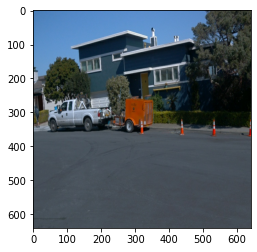

In [3]:
#explore the data format
box = np.zeros(10)
class_mapping = {1: 'vehicle', 2: 'pedestrian', 4:'cyclist'}
color_mapping = {1: 'red', 2: 'blue', 4:'green'}
colors = np.array([[1.0,0.0,0.0],[0.0,0.0,1.0]])
for batch in dataset_train.take(1):
    print(batch)
    image_raw = batch["image"].numpy()
    plt.imshow(image_raw)
    plt.show()

## Write a function to display an image and the bounding boxes

Implement the `display_images` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [28]:
def display_images(batch):
    class_mapping = {1: {'class': 'vehicle','color':'red'}, 2: {'class': 'pedestrian','color':'blue'}, 4: {'class': 'cyclist','color':'green'}}
    fig, ax = plt.subplots() 
    image_raw = batch["image"].numpy()
    ax.imshow(image_raw)
    image_shape = image_raw.shape
    for boxes, label in zip(batch["groundtruth_boxes"].numpy(), batch["groundtruth_classes"].numpy()):
            #normalized values
            ymin,xmin,ymax,xmax = boxes
            #input for patches.Rectangle
            xy = (xmin*image_shape[0], ymin*image_shape[1])
            width = (xmax - xmin)*image_shape[1]
            height = (ymax - ymin)*image_shape[0]
            rec = patches.Rectangle(xy, width, height, linewidth=1, edgecolor=class_mapping.get(label).get('color'), facecolor='none')
            ax.add_patch(rec)
    plt.axis("off")

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

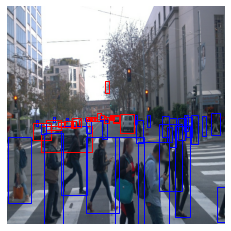

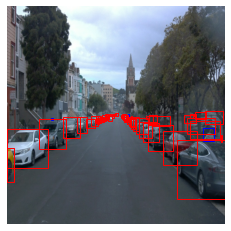

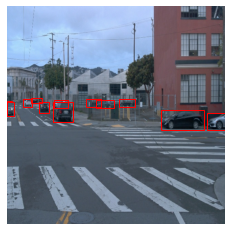

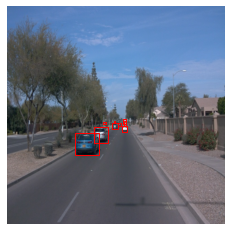

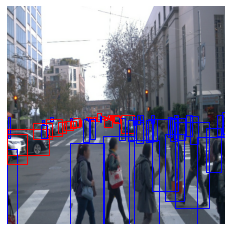

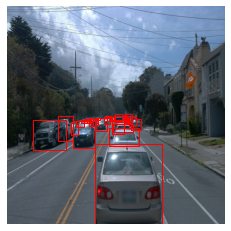

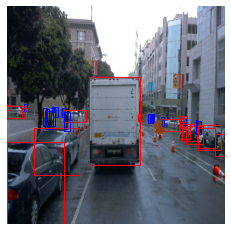

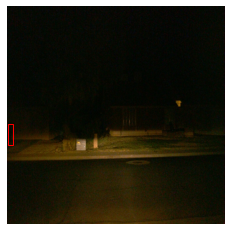

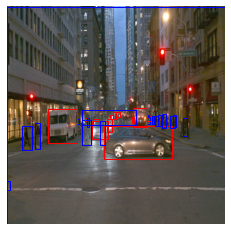

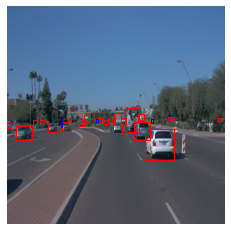

In [29]:
# Display 10 random images in dataset
for batch in dataset_train.shuffle(75).take(10):
    display_images(batch)
plt.show()

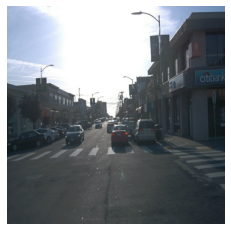

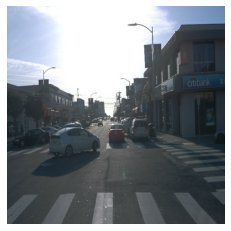

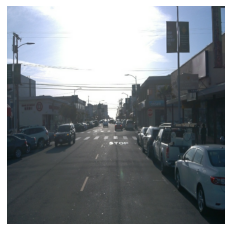

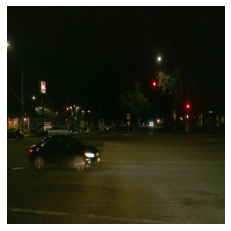

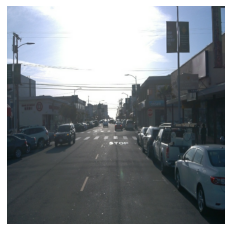

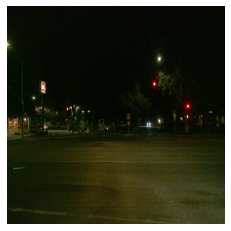

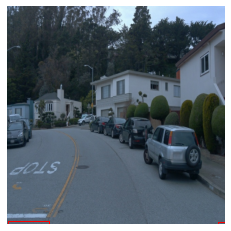

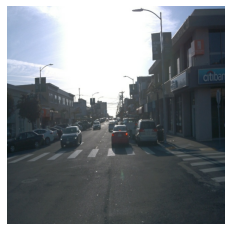

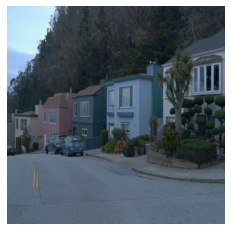

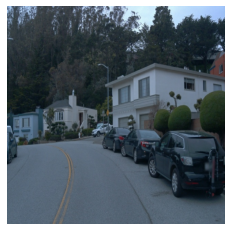

In [27]:
# Display 10 random images in test dataset
for batch in dataset_test.shuffle(75).take(10):
    display_images(batch)
plt.show()

There are no bounding boxes in the test data set! Seems to be an error or an error with the scaling!

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

Let's fetch the data for each frame:

In [7]:
data_list = []
frame_num = 0
for frame in dataset_train.take(30000):
    frame_label_count = np.zeros(5)
    for label in frame["groundtruth_classes"].numpy():
        frame_label_count[label] += 1 
        data_list.append([frame_num]+list(frame_label_count))
    frame_num += 1

In [8]:
class_mapping = {1: {'class': 'vehicle','color':'red'}, 2: {'class': 'pedestrian','color':'blue'}, 4: {'class': 'cyclist','color':'green'}}

In [9]:
df = pd.DataFrame(data_list, columns=["Batch"]+list(range(5))).astype("int32")
df.head()

,Batch,0,1,2,3,4
0,0,0,1,0,0,0
1,0,0,2,0,0,0
2,0,0,3,0,0,0
3,0,0,4,0,0,0
4,0,0,5,0,0,0


In [10]:
df = df.drop(labels=[0,3],axis=1)
df.head()

,Batch,1,2,4
0,0,1,0,0
1,0,2,0,0
2,0,3,0,0
3,0,4,0,0
4,0,5,0,0


### Count of classes

Let's check how often each class appear in all frames:

In [11]:
#fetch the count data by removing duplicates and group by batch and selecting the max values for each
counts = []
for key in class_mapping:
    count = df[["Batch",key]].drop_duplicates().groupby(["Batch"]).max().sum()[key]
    counts.append(count)
counts

[519214, 146336, 3730]

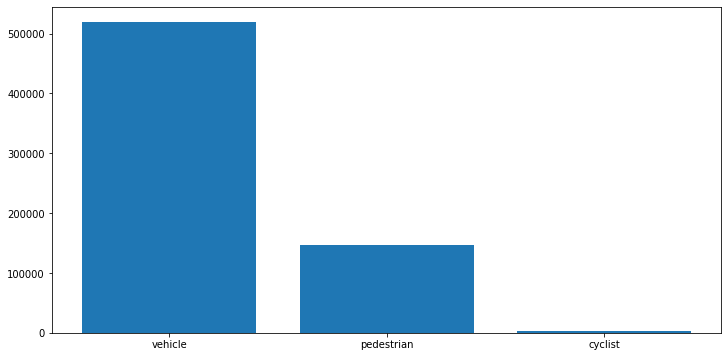

In [25]:
plt.figure(figsize=(12,6))
plt.bar([sub['class'] for sub in class_mapping.values() if 'class' in sub],counts)
plt.show()

It is notable that the dataset is very unbalanced. There are almost no cyclists compared to the other two classes. More data or fair resampling would be good for training.

### Distribution of classes

Here is a plot for each frame to count the appearance in frames:

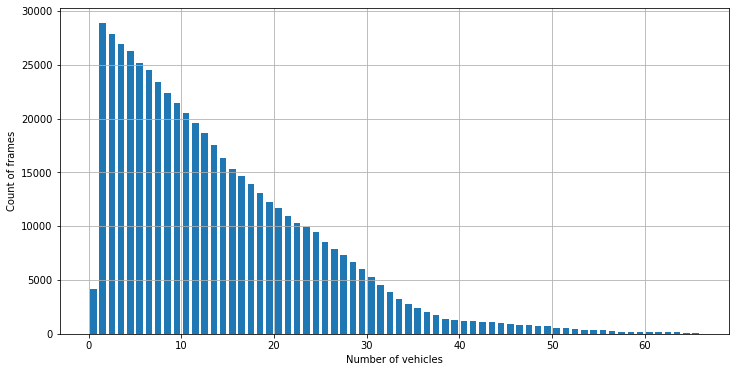

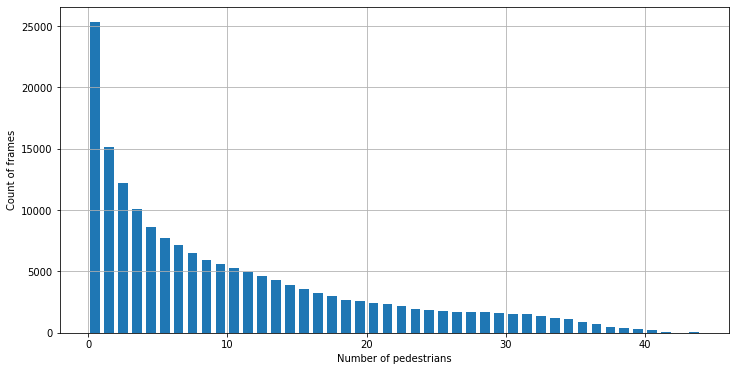

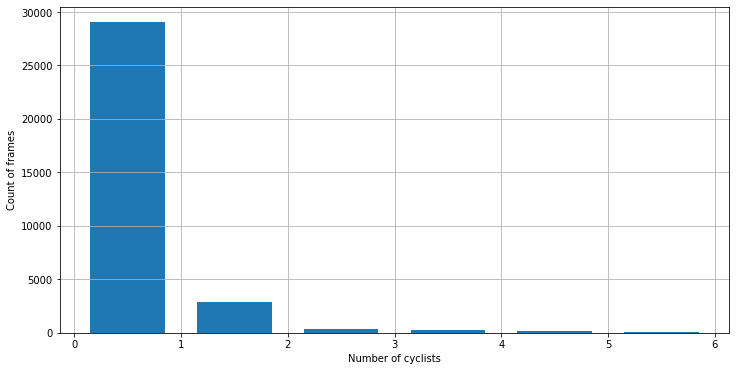

In [21]:
for key in class_mapping:
    df[["Batch",key]].drop_duplicates().hist(column=[key], bins=df[key].max(), rwidth=0.7, figsize=(12,6))
    plt.ylabel("Count of frames")
    plt.xlabel(f'Number of {class_mapping[key]["class"]}s')
    plt.title("")
    plt.show()